In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import requests
import robustats

from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from numba import njit
from io import BytesIO
from pathlib import Path
from functools import partial

sns.set_style("whitegrid")
np.random.seed(0)

## Note:

Execution of this notebook is kinda slow. On a standard laptop it can take up to 20 seconds.

## Question 3

### 1. (a)

#### Helper Functions

In [2]:
def load_data():
    """Load SCF panel data.
    
    Tries to load data from local if that fails will download the file
    from the webpage.
    
    Returns:
        df (pd.DataFrame): Dataframe with columns ["weight", "age", "income", "wealth"]. 
    
    """
    data_path = Path("data/SCFP2019.csv")
    columns = ["WGT", "AGE", "INCOME", "NETWORTH"]

    if data_path.is_file():
        df = pd.read_csv(data_path, usecols=columns)
    else:
        url = "https://www.federalreserve.gov/econres/files/scfp2019excel.zip"
        r = requests.get(url, allow_redirects=True)
        zf = zipfile.ZipFile(BytesIO(r.content))
        df = pd.read_csv(zf.open("SCFP2019.csv"), usecols=columns)

    df = df.rename(
        columns={
            "WGT": "weight",
            "AGE": "age",
            "INCOME": "income",
            "NETWORTH": "wealth",
        }
    )
    return df

In [3]:
def weighted_median(sample, weight):
    """Compute weighted median.
    
    See https://github.com/FilippoBovo/robustats for more information
    on weighted medians.
    
    Args:
        sample (list-like): Sample points.
        weight (list-like): Weights for sample points.
        
    Returns:
        median (float): Weighted median.
    
    """
    sample = np.array(sample).flatten()
    weight = np.array(weight).flatten()
    median = robustats.weighted_median(sample, weight)
    return median

In [4]:
def extract_age_window(df, age, left_window, right_window):
    """Extract window from data frame using age column.
    
    Args:
        df (pd.DataFrame): Data frame with column "age".
        age (int): Value where the window shall be set.
        left_window (int): How many values to the left to consider.
        right_window (int): How many values to the right to consider.
        
    Returns:
        window (pd.DataFrame): The subsetted data frame with only
            rows that have column "age" in in the intverval
            [age - left_window, age + right_window].
    
    """
    left_window = age - left_window
    right_window = age + right_window
    window = df.query("@left_window <= age <= @right_window").copy()
    return window

In [5]:
def time_to_age(time):
    """Convert periods of model to age in data set."""
    return time + 24

In [6]:
def rolling_weighted_median(df, last_period, left_window, right_window):
    """Compute rolling weighted median.
    
    Returns:
        results (pd.DataFrame): Frame containing the weighted median for
            column "income" and "weight" given all periods. Has index "age"
            and columns "income", "weigth", "ratio".
    
    """
    results = pd.DataFrame(columns=["age", "income", "wealth"], dtype=float).set_index(
        "age"
    )
    for time in range(1, last_period + 1):
        age = time_to_age(time)
        window = extract_age_window(df, age, left_window, right_window)
        income = weighted_median(window["income"], window["weight"])
        wealth = weighted_median(window["wealth"], window["weight"])
        results.loc[age, :] = (income, wealth)

    results["ratio"] = results["wealth"] / results["income"]
    return results

In [7]:
def plot_profiles(profiles, last_period=60):
    """Plot profiles.
    
    Args:
        profiles (list): List of dictionaries. Each dictionary must
            contain entries "values", "col" and "label".
        last_period (int): Last period of model.
    
    """
    profiles = profiles if isinstance(profiles, list) else [profiles]
    time = time_to_age(np.arange(last_period) + 1)

    fig, ax = plt.subplots(1)
    fig.set_size_inches(15, 8)

    for profile in profiles:
        sns.lineplot(
            x=time,
            y=profile["values"],
            ax=ax,
            linewidth=2,
            color=profile["col"],
            legend="brief",
            label=profile["label"],
        )

    ax.set(ylabel="Wealth-Income Ratio", xlabel="Age")
    ax.set_frame_on(False)
    ax.xaxis.label.set_size(13)
    ax.yaxis.label.set_size(13)
    plt.legend(frameon=False, bbox_to_anchor=[0.3, 0.85], prop={"size": 13})
    plt.show()

#### Computation

In [8]:
raw_data = load_data()

In [9]:
df = rolling_weighted_median(raw_data, last_period=60, left_window=2, right_window=2)

In [10]:
DATA_PROFILE = {
    "values": df["ratio"].values.copy(),
    "col": "C0",
    "label": "Data",
}

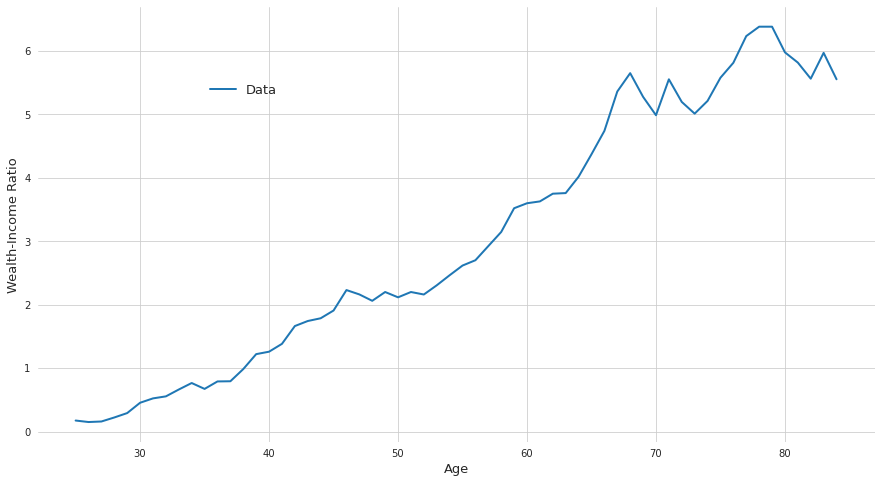

In [11]:
plot_profiles(DATA_PROFILE)

### 1. (b)

In [12]:
def compute_normalized_income(df, retirement_period):
    """Normalize income between age 25 and 64.
    
    Args:
        df (pd.DataFrame): Data frame resulting from function call from
            function ``rolling_weighted_median``.
        retirement_period (int): Retirement period (parameter in model).
    
    Returns:
        normalized (pd.Series): Normalized income.
    
    """
    income = df["income"].loc[time_to_age(1) : time_to_age(retirement_period)]
    normalized = income / income.mean()
    return normalized

In [13]:
def construct_income_stream(df, tau, retirement_period, last_period):
    """Construct income stream.

    Args:
        df (pd.DataFrame): Data frame resulting from function call from
            function ``rolling_weighted_median``.
        tau (float): Pension (parameter in model).
        retirement_period (int): Retirement period (parameter in model).
        last_period (int): Last period (parameter in model).
    
    Returns:
        stream (np.ndarray): 1d array income stream.
    
    """
    normalized = compute_normalized_income(df, retirement_period)
    n_retirement_periods = last_period - retirement_period
    pension = pd.Series(
        n_retirement_periods * [tau],
        index=range(time_to_age(retirement_period + 1), time_to_age(last_period) + 1),
    )
    stream = normalized.append(pension).values
    return stream

In [14]:
@njit
def consumption(old_wealth, new_wealth, income, interest):
    """Compute consumption from wealth, income and interest.
    
    The formula from the model is given by:
    
        c_t = (1 + r) a_t + y_t - a_{t + 1} ,
        
    where a_t denotes the wealth at time t, y_t the income at time
    t and r the interest rate, respectively
    
    Args:
        old_wealth (np.ndarray or float): New wealth level.
        new_wealth (np.ndarray or float): Old wealth level.
        income (float): Income level.
        interest (float): Interest rate.
        
    Return:
        consum (np.ndarray or float): Consumption level.
    
    """
    consum = income + (1 + interest) * old_wealth - new_wealth
    return consum

In [15]:
@njit
def utility_func_robust(consum, tolerance=10e-7):
    """Robust log-utility function.
    
    Args:
        consum (np.ndarray): Consumption levels.
        tolerance (float): Consumption levels below tolerance get
            negative infinity utility.
        
    Returns:
        utility (np.ndarray): Log-utility where consumption levels that
            are numerically close to zero are set to negative infinity.
            
    """
    illegal = consum < tolerance
    consum[illegal] = 1
    utility = np.log(consum)
    utility[illegal] = -np.inf
    return utility

In [16]:
@njit
def solve_model(wealth_grid, income_stream_array, interest, beta, last_period):
    """Solve model via backward induction.
    
    Args:
        wealth_grid (np.ndarray or list-like): List of discretized wealth
            values of which we optimize.
        income_stream_array (np.ndarray): Income stream resulting from
            function call of ``construct_income_stream``.
        interest (float): Interest rate (parameter in model).
        beta (float): Discount factor (parameter in model).
        last_period (int): Last period (parameter in model).
        
    Returns:
        policy_index (np.ndarray): Policy array of shape
            (last_period, len(wealth_grid)). Results are given in terms
            of indices of paramater wealth_grid.
    
    """
    value_array = np.zeros((last_period + 1, len(wealth_grid)))
    policy_index = np.empty((last_period, len(wealth_grid)))

    for t in range(last_period - 1, -1, -1):

        # algorithm:
        for j, wealth in enumerate(wealth_grid):
            old_values = value_array[t + 1, :]
            income = income_stream_array[t]
            consum = consumption(wealth, wealth_grid, income, interest)
            utility = utility_func_robust(consum)
            to_max = utility + beta * old_values
            argmax = np.argmax(to_max)
            value_array[t, j] = to_max[argmax]
            policy_index[t, j] = argmax

    return policy_index

In [17]:
def compute_policy_profile(initial_wealth, policy, wealth_grid):
    """Compute policy profile.
    
    Args:
        initial_wealth (float): Initial wealth where to start the
            profile from.
        policy (np.ndarray): Policy array solution resulting from
            function call of ``solve_model``. Has shape
            (last_period, len(wealth_grid)).
        wealth_grid (np.ndarray or list-like): List of discretized wealth
            values of which we optimize.
    
    Returns:
        policy_profile (np.ndarray): Policies for each period. Has shape
            (last_period,)
    
    """
    policy = policy.astype(int)
    last_period = len(policy)
    policy_profile = np.zeros(last_period + 1, dtype=int)

    initial_wealth_index = np.argmin(np.abs(initial_wealth - wealth_grid))
    policy_profile[0] = initial_wealth_index
    for t in range(last_period):
        policy_profile[t + 1] = policy[t, policy_profile[t]]

    policy_profile = wealth_grid[policy_profile.astype(int)][1:]
    return policy_profile

#### Computation:

In [18]:
# parameters
wealth_grid = np.linspace(0, 16, 500)
initial_wealth = 0.15

In [19]:
# solving the model
income_stream_array = construct_income_stream(
    df, tau=0.5, retirement_period=40, last_period=60
)
policy = solve_model(
    wealth_grid, income_stream_array, beta=0.96, interest=0.04, last_period=60
)
policy_profile = compute_policy_profile(initial_wealth, policy, wealth_grid)

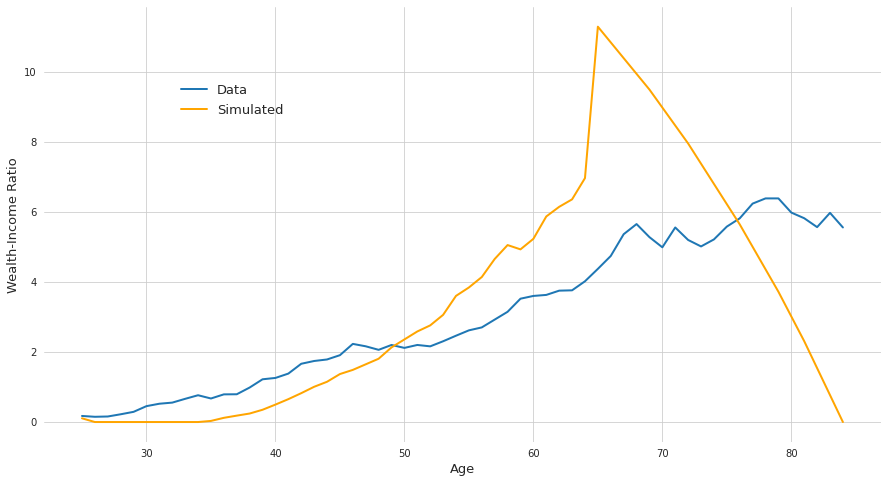

In [20]:
# plot results
profiles = [
    DATA_PROFILE,
    {
        "values": policy_profile / income_stream_array,
        "col": "orange",
        "label": "Simulated",
    },
]

plot_profiles(profiles)

### 2.
#### Helper Functions:

In [21]:
def _criterion_internal(
    beta,
    metric,
    data_profile,
    initial_wealth,
    income_stream_array,
    wealth_grid,
    interest,
    last_period,
):
    """Criterion function.
    
    Args:
        beta (float): Discount factor (parameter in model).
        metric (callable): Metric function.
        data_profile (np.ndarray): Data profile as computed above.
        income_stream_array (np.ndarray): Income stream resulting from
            function call of ``construct_income_stream``.
        wealth_grid (np.ndarray or list-like): List of discretized wealth
            values of which we optimize.
        interest (float): Interest rate (parameter in model).
        last_period (int): Last period (parameter in model).
    
    
    Returns:
        crit_value (float): Metric accounting for how much the simulated profile
            differs from the data profile.
    
    """
    policy = solve_model(
        wealth_grid, income_stream_array, interest, beta, last_period
    )
    policy_profile = compute_policy_profile(initial_wealth, policy, wealth_grid)
    simulated_profile = policy_profile / income_stream_array
    crit_value = metric(simulated_profile, data_profile)
    return crit_value

In [22]:
def get_criterion_func(
    metric,
    df,
    initial_wealth,
    wealth_grid,
    retirement_period,
    last_period,
    tau,
    interest,
):
    """Construct criterion function for optimization."""
    income_stream_array = construct_income_stream(
        df, tau, retirement_period, last_period
    )

    params = {
        "data_profile": df["ratio"].values,
        "initial_wealth": initial_wealth,
        "income_stream_array": income_stream_array,
        "wealth_grid": wealth_grid,
        "interest": interest,
        "last_period": last_period,
        "metric": metric,
    }

    crit_func = partial(_criterion_internal, **params)
    return crit_func

#### Use optimizer to find optimal beta:

In a simple problem like this it would be much more efficient to iterate a few times over some grid. However in proper models this is impossible as the grid size grows exponentially in number of parameters. In these cases one has to use optimizers. Therefore we will also make use of optimizers here.

Using ``mean_absolute_error``:

In [23]:
crit_func = get_criterion_func(
    metric=mean_absolute_error,
    df=df,
    initial_wealth=0.65,
    wealth_grid=wealth_grid,
    retirement_period=40,
    last_period=60,
    tau=0.5,
    interest=0.04,
)

In [24]:
result = minimize(crit_func, x0=0.96, method="Nelder-Mead")

In [25]:
absolute_error_optimum = result["x"][0]
absolute_error_optimum

0.9532499999999999

Using ``mean_squared_error``:

In [26]:
crit_func = get_criterion_func(
    metric=mean_squared_error,
    df=df,
    initial_wealth=0.65,
    wealth_grid=wealth_grid,
    retirement_period=40,
    last_period=60,
    tau=0.5,
    interest=0.04,
)

In [27]:
result = minimize_scalar(crit_func, bounds=(0, 1), method="golden")

In [28]:
squared_error_optimum = result["x"]
squared_error_optimum

0.9547121357654698

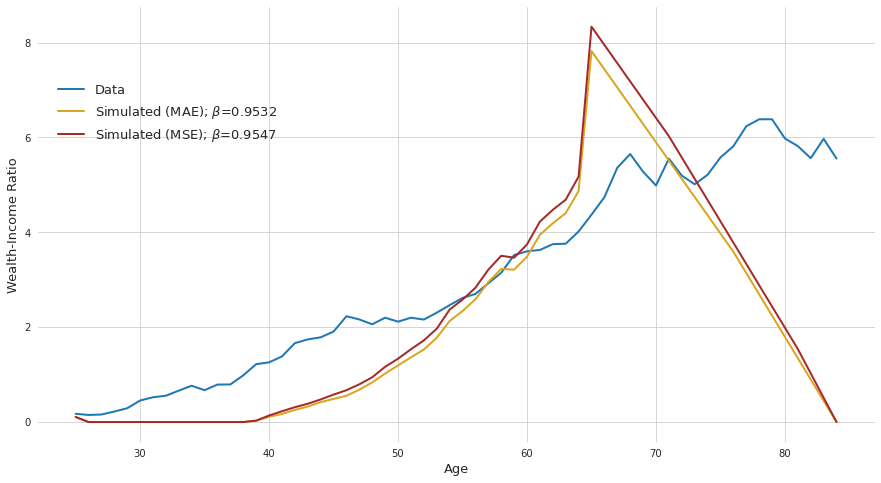

In [29]:
# solve model for optimal betas and plot results:
profiles = [DATA_PROFILE]

for metric_name, beta in {
    "mae": absolute_error_optimum,
    "mse": squared_error_optimum,
}.items():
    policy = solve_model(
        wealth_grid, income_stream_array, beta=beta, interest=0.04, last_period=60
    )
    policy_profile = compute_policy_profile(initial_wealth, policy, wealth_grid)

    label = "Simulated (MAE)" if metric_name == "mae" else "Simulated (MSE)"
    label += r"; $\beta$=" + f"{beta:.4f}"
    profile = {
        "values": policy_profile / income_stream_array,
        "col": "goldenrod" if metric_name == "mae" else "brown",
        "label": label,
    }
    profiles.append(profile)

plot_profiles(profiles)